In [485]:
from tsai.all import *
from tsai.basics import *


device = "cuda" if torch.cuda.is_available() else 'cpu'

dataname = 'Car'
X, y, splits = get_classification_data(dataname, split_data=False)
model_name = 'HydraPlus'
tfms = [None, TSClassification()]
batch_tfms = TSStandardize()
# clf = TSClassifier(X, y, splits=splits, path='../models', arch=model_name, tfms=tfms, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph(),device=device)
# clf.fit_one_cycle(100, 3e-4)
# clf.export(f"{model_name}-{dataname}.pkl") 

In [ ]:
DATASETS = get_UCR_univariate_list ()


['ACSF1',
 'Adiac',
 'AllGestureWiimoteX',
 'AllGestureWiimoteY',
 'AllGestureWiimoteZ',
 'ArrowHead',
 'Beef',
 'BeetleFly',
 'BirdChicken',
 'BME',
 'Car',
 'CBF',
 'Chinatown',
 'ChlorineConcentration',
 'CinCECGTorso',
 'Coffee',
 'Computers',
 'CricketX',
 'CricketY',
 'CricketZ',
 'Crop',
 'DiatomSizeReduction',
 'DistalPhalanxOutlineAgeGroup',
 'DistalPhalanxOutlineCorrect',
 'DistalPhalanxTW',
 'DodgerLoopDay',
 'DodgerLoopGame',
 'DodgerLoopWeekend',
 'Earthquakes',
 'ECG200',
 'ECG5000',
 'ECGFiveDays',
 'ElectricDevices',
 'EOGHorizontalSignal',
 'EOGVerticalSignal',
 'EthanolLevel',
 'FaceAll',
 'FaceFour',
 'FacesUCR',
 'FiftyWords',
 'Fish',
 'FordA',
 'FordB',
 'FreezerRegularTrain',
 'FreezerSmallTrain',
 'Fungi',
 'GestureMidAirD1',
 'GestureMidAirD2',
 'GestureMidAirD3',
 'GesturePebbleZ1',
 'GesturePebbleZ2',
 'GunPoint',
 'GunPointAgeSpan',
 'GunPointMaleVersusFemale',
 'GunPointOldVersusYoung',
 'Ham',
 'HandOutlines',
 'Haptics',
 'Herring',
 'HouseTwenty',
 'Inli

In [460]:
pd.DataFrame(np.array(X.tolist())[:,0,:])
Y_df = pd.DataFrame(np.array(y.tolist())).astype('int')

Y_df['1'] = Y_df[0]
grouped_df = Y_df.groupby([0]).count()/len(Y_df)

grouped_df.values




array([[0.49908759],
       [0.50091241]])

In [486]:
from tsai.inference import load_learner


model_name = 'HydraPlus'
clf = load_learner(f"../models/{model_name}-{dataname}.pkl",cpu=False)
#probas, target, preds = clf.get_X_preds(X[0], y[0])
print(clf)

In [36]:
y

memmap(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
        '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1',
        '1', '1', '1', '1'], dtype='<U1')

In [35]:
probabilitis = torch.softmax(clf.model(torch.tensor(X[3]).unsqueeze(0).to(device)),dim=-1)

#print(probabilitis)
torch.sort(probabilitis,descending=True)[1][0][1]

tensor(1, device='cuda:0')

In [38]:
import torch
import torch.nn as nn
import torch.fft as fft
from tslearn.metrics import SoftDTWLossPyTorch

class: 3
target : 2


100%|██████████| 500/500 [00:05<00:00, 87.82it/s] 


tensor([[0.0204, 0.1925, 0.5378, 0.2493]], device='cuda:0')


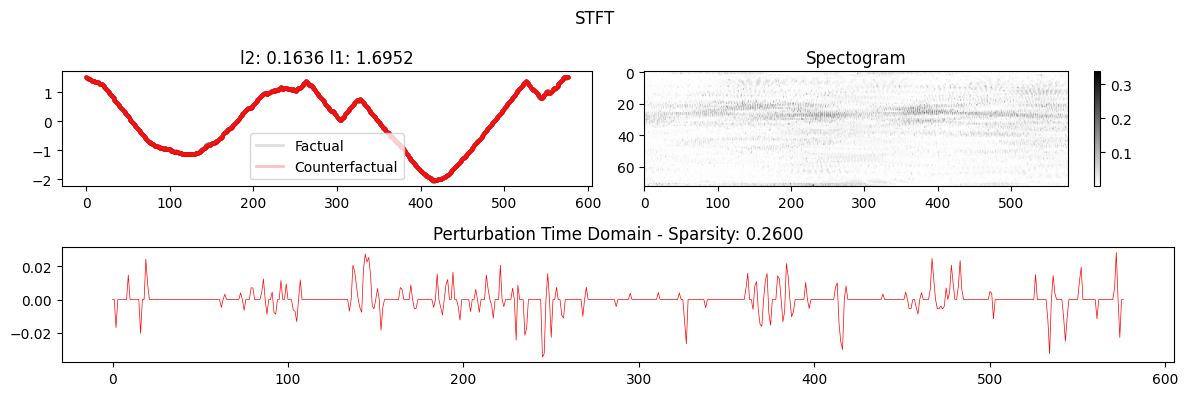

In [498]:
class BasePerturbation(nn.Module):
    def forward(self, x):
        raise NotImplementedError

    def regularization(self, x, x_cf):
        return torch.tensor(0., device=x.device)


class TimeL2Perturbation(BasePerturbation):
    def __init__(self, C, T, init_scale=1e-3):
        super().__init__()
        self.delta = nn.Parameter(init_scale * torch.randn(1, C, T))

    def forward(self, x):
        return x + self.delta

    def regularization(self, x, x_cf):
        #return self.delta.pow(2).mean()
        return self.delta.abs().sum()



class FrequencyPerturbation(BasePerturbation):
    def __init__(self, C, T, init_scale=1e-3):
        super().__init__()
        self.delta_real = nn.Parameter(init_scale * torch.randn(1, C, T))
        self.delta_imag = nn.Parameter(init_scale * torch.randn(1, C, T))

    def forward(self, x):
        X = torch.fft.fft(x, dim=-1, norm="ortho")
        delta = self.delta_real + 1j * self.delta_imag
        X_cf = X + delta
        x_ifft = torch.fft.ifft(X_cf, dim=-1, norm="ortho")
        return torch.view_as_real(x_ifft)[..., 0]

    def regularization(self, x, x_cf):
        return (
            self.delta_real.pow(2).mean() +
            self.delta_imag.pow(2).mean()
        )



class STFTPerturbation(BasePerturbation):
    def __init__(
        self,
        C,
        T,
        n_fft=16,
        hop_length=None,
        win_length=None,
        init_scale=1e-2,
        window_fn=torch.hann_window,
    ):
        super().__init__()

        self.n_fft = n_fft
        self.hop_length = hop_length or n_fft // 4
        self.win_length = win_length or n_fft
        self.window = window_fn(self.win_length)

        # compute STFT shape
        dummy = torch.zeros(1, C, T)
        Z = torch.stft(
            dummy.view(-1, T),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            return_complex=True,
        )

        F, TT = Z.shape[-2], Z.shape[-1]

        # learnable perturbation in TF space
        self.delta_real = nn.Parameter(init_scale * torch.randn(1, C, F, TT))
        self.delta_imag = nn.Parameter(init_scale * torch.randn(1, C, F, TT))
        self.mask_logits = nn.Parameter(torch.randn(1, C, F, TT))
        self.N = C*F*TT

    def forward(self, x):
        """
        x: (B, C, T)
        """
        B, C, T = x.shape
        window = self.window.to(x.device)

        # STFT (merge B and C for efficiency)
        Z = torch.stft(
            x.view(B * C, T),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=window,
            return_complex=True,
        )

        Z = Z.view(B, C, *Z.shape[-2:])
        delta = (self.delta_real + 1j * self.delta_imag)*torch.sigmoid(self.mask_logits)
        Z_cf = Z + delta

        # inverse STFT
        x_cf = torch.istft(
            Z_cf.view(B * C, *Z_cf.shape[-2:]),
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=window,
            length=T,
        )

        return x_cf.view(B, C, T)

    def regularization(self, x, x_cf):
        mask = torch.sigmoid(self.mask_logits)
        #return torch.svd(self.delta_real[0,0,:,:],compute_uv=False).S.sum
        return (
        mask.sum()/self.N +  # sparsity
        (self.delta_real * mask).abs().pow(2).sum()
    )
        # return (
        #     self.delta_real.abs().sum() +
        #     self.delta_imag.abs().sum()
        # )


class TSCounterfactualGenerator:
    def __init__(
        self,
        learner: TSClassifier,
        perturbation_cls,
        lam_perturb=1e-4,
        lam_time=0.0,
        lam_clf=1.0,
        lr=1e-2,
        steps=500,
        device=None,
        **perturb_kwargs
    ):
        self.learner = learner
        self.model = learner.model.eval()
        self.model.to(device)

        for p in self.model.parameters():
            p.requires_grad = False

        self.loss_func = learner.loss_func
        self.lam_perturb = lam_perturb
        self.lam_time = lam_time
        self.lam_clf = lam_clf
        self.lr = lr
        self.steps = steps

        self.device = device or learner.dls.device
        self.perturbation_cls = perturbation_cls
        self.perturb_kwargs = perturb_kwargs
        self.sdtw = SoftDTWLossPyTorch(gamma=0.1)

    def generate(self, x, target):
        x = x.to(self.device).float()
        target = target.to(self.device)

        B, C, T = x.shape

        perturb = self.perturbation_cls(C=C, T=T, **self.perturb_kwargs)
        perturb = perturb.to(self.device)

        opt = torch.optim.Adam(perturb.parameters(), lr=self.lr)
        #opt = torch.optim.AdamW(perturb.parameters(), lr=self.lr, weight_decay=0.01)
        #opt = torch.optim.LBFGS(perturb.parameters())

        losses = []

        for _ in tqdm(range(self.steps)):
            opt.zero_grad()

            x_cf = perturb(x)
            #print(x_cf.device)
            logits = self.model(x_cf)

            clf_loss = self.loss_func(logits, target)

            probas = torch.softmax(logits,dim=-1)
    
            pert_reg = perturb.regularization(x, x_cf)
            #print('pert_reg',pert_reg)
            #time_reg = self.sdtw(x_cf,x)#
            #time_reg = (x_cf - x).pow(2).sum()
            time_reg = (x_cf-x).abs().sum()

            cur_dist = float((x-x_cf).pow(2).sum())
            #print(cur_dist)


            lr_clf = self.lam_clf
            lr_perturb = self.lam_perturb
            lr_time = self.lam_time

            if self.lam_clf is None:
                lr_clf = max(1.5, cur_dist / 10.0)  # Start with smaller regularization
               #print(lr_clf)
            if self.lam_time is None:
                lr_time = 0.05#0.005#max(0.5, cur_dist / 100.0) 
            if self.lam_perturb is None:
                lr_perturb = 0.5#max(0.15, cur_dist / 100.0)   # Smaller step increases


            loss = lr_clf*(clf_loss**2) + lr_perturb * pert_reg**2 + lr_time * time_reg**2- 10*(-probas*torch.log(probas)).sum()**0.5
            loss.backward()
            opt.step()

            losses.append(loss.item())


            x_cf = torch.where((x_cf-x).abs().pow(2)<1e-5,x,x_cf)
        return {
            "x_cf": x_cf.detach(),
            "losses": losses,
            "perturbation": perturb
        }



device = "cuda" if torch.cuda.is_available() else 'cpu'

plt.style.use('default')
i = -1
x = torch.tensor(X[i]).unsqueeze(0).to(device)  # (1, C, T)

cf_gen = TSCounterfactualGenerator(
    clf,
    perturbation_cls=STFTPerturbation,
    lam_time=None,#0.25,
    lam_clf=3,#5,
    steps=500,
    hop_length=1,
    n_fft=int(x.shape[2]//4),
    device=device,
    init_scale=1e-3,

)


classmap  ={s: c for c,s in enumerate(set(y.tolist()))}

classmap ={'-1':1,'1':0}
classmap ={'1':1,'2':0}
classmap = {'0':1,'1':0}


probabilitis = torch.softmax(clf.model(x),dim=-1)

print(f"class: {torch.argmax(probabilitis)}")
target = torch.sort(probabilitis,descending=True)[1][0][1].to(device)
#target = torch.tensor((classmap[y[i]]),dtype=torch.long).to(device)
print(f"target : {target}")



cf = cf_gen.generate(x, target)

x_cf = cf["x_cf"]
#x_cf = torch.where((x_cf-x).abs().pow(2)<1e-6,x,x_cf)


fig = plt.figure(figsize=(12,4))
fig.suptitle("STFT")
ax0 = fig.add_subplot(221)
ax0.plot(x.detach().cpu().numpy().flatten(),label='Factual',c='gray',lw=2.0,alpha=0.25)
ax0.plot(x_cf.detach().cpu().flatten(),label='Counterfactual',c='red',lw=2.0,alpha=0.25)
ax0.scatter(np.arange(x.shape[2]),x.detach().cpu().numpy().flatten(),marker='o',color='gray',s=5)
ax0.scatter(np.arange(x.shape[2]),x_cf.detach().cpu().flatten(),marker='o',color='red',s=5)
#ax0.set_title(f"DTW: {cf_gen.sdtw(x_cf,x).detach().cpu().numpy()[0]:.4f}")
ax0.set_title(f"l2: {(x_cf-x).pow(2).sum().detach().cpu().numpy()**0.5:.4f} l1: {(x_cf-x).abs().sum().detach().cpu().numpy():.4f}")
ax0.legend()
ax1 = fig.add_subplot(222)



try:
    im = ax1.imshow(cf['perturbation'].delta_real.detach().abs().cpu().numpy()[0,0,:,:],cmap='binary',aspect='auto')
    fig.colorbar(im)
    ax1.set_title('Spectogram')
except:
    #ax1.plot(cf['perturbation'].delta_real.detach().cpu().numpy().flatten())
    im = ax1.imshow(torch.stft(cf['perturbation'].delta.squeeze(0),n_fft=x.shape[2]//2,hop_length=4,return_complex=True)[0,:,:].detach().abs().cpu().numpy().real,cmap='binary',aspect='auto')
    fig.colorbar(im)
    ax1.set_title('Spectogram')
#ax1.hist(cf['delta_real'].flatten())
ax2 = fig.add_subplot(212)
ax2.set_title(f'Perturbation Time Domain - Sparsity: {((x_cf!=x).sum()/x.shape[2]).detach().cpu().numpy():.4f}')
ax2.plot(x.detach().cpu().numpy().flatten()-x_cf.detach().cpu().numpy().flatten(),color='red',lw=0.5)
# #ax2.set_yscale('log')
print(torch.softmax(clf.model(x_cf.detach().to(device)),1))
fig.tight_layout()

In [259]:
c=0.5
np.sum(np.array([c,1-c])*np.log(np.array([c,1-c])))

-0.6931471805599453

In [ ]:
import numpy as np

import torch
import torch.nn as nn

from torch.optim import Adam


def detach_to_numpy(data):
    # move pytorch data to cpu and detach it to numpy data
    return data.cpu().detach().numpy()


def numpy_to_torch(data, device):
    # convert numpy array to pytorch and move it to the device
    return torch.from_numpy(data).float().to(device)


def manhattan_dist(x, y):
    return torch.sum(torch.abs(x - y))


def euclidean_dist(x, y):
    return torch.sqrt(torch.sum(torch.abs(x - y) ** 2))


####
# Counterfactual Explanations without Opening the Black Box: Automated Decisions and the GDPR
#
# https://arxiv.org/abs/1711.00399
#
#
# This is a genetic model-agnostic variant using the sensitivity of the model.
#
####
def wachter_genetic_cf(sample, model, target=None, max_steps=1000, step_size=0.1, verbose=False):

    device = next(model.parameters()).device

    def model_predict(data):
        # Ensure proper input format for model
        if isinstance(data, np.ndarray):
            data_tensor = torch.tensor(data, dtype=torch.float32, device=device)
        else:
            data_tensor = data
            
        # Handle different input shapes for model
        if len(data_tensor.shape) == 1:
            data_tensor = data_tensor.reshape(1, 1, -1)
        elif len(data_tensor.shape) == 2:
            if data_tensor.shape[0] > data_tensor.shape[1]:
                data_tensor = data_tensor.T
            data_tensor = data_tensor.unsqueeze(0)
            
        return detach_to_numpy(model(data_tensor))

    # Convert sample to proper format for processing
    sample_flat = sample.reshape(-1)
    sample_cf = np.copy(sample_flat)
    
    # Get initial prediction
    y_cf = model_predict(sample_cf.reshape(sample.shape))[0]
    label_cf = np.argmax(y_cf)
    
    if not target:
        # Find the class with second highest probability (not just binary 0/1)
        sorted_indices = np.argsort(y_cf)[::-1]  # Sort in descending order
        target = int(sorted_indices[1])  # Second most likely class
    
    if verbose:
        print(f"Wachter Genetic: Original class {label_cf}, Target class {target}, step_size={step_size}")

    # Iterate until the counterfactual prediction is different from the original prediction or the maximum number of steps is reached
    for step in range(max_steps):
        # Compute the model prediction for each possible change to the input features
        y_preds = []
        feature_changes = []
        
        for i in range(len(sample_flat)):
            # plus variant
            sample_plus = sample_cf.copy()
            sample_plus[i] += step_size
            y_pred_plus = model_predict(sample_plus.reshape(sample.shape))[0]
            y_preds.append(y_pred_plus)
            feature_changes.append((i, +step_size))

            # minus variant
            sample_minus = sample_cf.copy()
            sample_minus[i] -= step_size
            y_pred_minus = model_predict(sample_minus.reshape(sample.shape))[0]
            y_preds.append(y_pred_minus)
            feature_changes.append((i, -step_size))

        # Find the change that results in the greatest increase in target class probability
        y_preds = np.array(y_preds)
        target_improvements = y_preds[:, target] - y_cf[target]  # How much target class probability improves
        
        best_change_idx = np.argmax(target_improvements)
        best_feature_idx, best_step = feature_changes[best_change_idx]
        best_improvement = target_improvements[best_change_idx]
        
        # Apply the best change
        sample_cf[best_feature_idx] += best_step
        
        # Get new prediction
        y_cf = model_predict(sample_cf.reshape(sample.shape))[0]
        current_class = np.argmax(y_cf)
        current_target_prob = y_cf[target]
        
        # Debug output every 200 steps
        if verbose and step % 200 == 0:
            print(f"Wachter Genetic step {step}: pred_class={current_class}, target={target}, "
                  f"target_prob={current_target_prob:.4f}, improvement={best_improvement:.4f}")
        
        # If the counterfactual prediction matches target, return it
        if current_class == target:
            if verbose:
                print(f"Wachter Genetic: Found counterfactual at step {step}")
            return sample_cf.reshape(sample.shape), y_cf

    if verbose:
        print(f"Wachter Genetic: Max steps reached. Final target probability: {y_cf[target]:.4f}")
    # If the maximum number of steps is reached without finding a counterfactual, return None
    return None, None


####
# Counterfactual Explanations without Opening the Black Box: Automated Decisions and the GDPR
#
# https://arxiv.org/abs/1711.00399
#
#
# This is a optimization variant using the gradients of the model.
#
####
def wachter_gradient_cf(sample,
                        dataset,
                        model,
                        target=None,
                        lb=None,
                        lb_step=None,
                        max_cfs=1000,
                        full_random=False,
                        distance='euclidean',
                        verbose=False):
    """Gradient-based Wachter counterfactual implemented with pure PyTorch tensors.

    Fixes errors caused by mixing torch tensors with numpy/scipy indexing (e.g.
    passing a torch index into a numpy array). Operates on tensors on the same
    device as the model and keeps conversions to/from numpy only for I/O.
    """
    device = next(model.parameters()).device

    # prepare input shapes: ensure consistent with model expectations
    # Convert sample to the format expected by the model: (batch, channels, length)
    sample_tensor = torch.tensor(sample, dtype=torch.float32, device=device)
    if len(sample_tensor.shape) == 1:
        sample_tensor = sample_tensor.reshape(1, 1, -1)  # (length,) -> (1, 1, length)
    elif len(sample_tensor.shape) == 2:
        if sample_tensor.shape[0] > sample_tensor.shape[1]:
            sample_tensor = sample_tensor.T  # Assume (length, channels) -> (channels, length)
        sample_tensor = sample_tensor.unsqueeze(0)  # Add batch dimension
    
    sample_t = sample_tensor.clone()

    # initial prediction and label
    y_cf = detach_to_numpy(model(sample_t))[0]
    label_cf = int(np.argmax(y_cf))
    if target is None:
        # Find the class with second highest probability (not just binary 0/1)
        sorted_indices = np.argsort(y_cf)[::-1]  # Sort in descending order
        target = int(sorted_indices[1])  # Second most likely class
    target_t = torch.tensor([target], dtype=torch.long, device=device)
    
    if verbose:
        print(f"Wachter Gradient: Original class {label_cf}, Target class {target}")

    # distance functions using torch tensors
    def dist(x, y):
        if distance == 'euclidean':
            return euclidean_dist(x, y)
        return manhattan_dist(x, y)

    # classification loss
    ce_loss = nn.CrossEntropyLoss()

    # loss function combining classification loss and distance
    def loss_fn(pred, cf):
        cls_term = ce_loss(pred, target_t)  # pred shape (1, num_classes)
        return lb * (cls_term ** 2) + dist(sample_t, cf)

    # initialize candidate counterfactual - start from original sample with noise
    sample_cf = sample_t.clone().detach()
    # Add small random noise to start optimization
    noise = torch.randn_like(sample_cf) * 0.1
    sample_cf = sample_cf + noise

    # if not fully random, seed candidate from a random dataset element
    if not full_random:
        dataset_len = len(dataset)
        ridx = int(torch.randint(0, dataset_len, (1,)).item())
        x0 = dataset[ridx][0]
        x0_tensor = torch.tensor(x0, dtype=torch.float32, device=device)
        
        # Handle different input shapes for dataset sample
        if len(x0_tensor.shape) == 1:
            x0_tensor = x0_tensor.reshape(1, 1, -1)
        elif len(x0_tensor.shape) == 2:
            if x0_tensor.shape[0] > x0_tensor.shape[1]:
                x0_tensor = x0_tensor.T
            x0_tensor = x0_tensor.unsqueeze(0)
        
        sample_cf = x0_tensor.clone()

    # default lb and lb_step computed from current distance if not provided
    cur_dist = float(dist(sample_t, sample_cf).item())
    if lb is None:
        lb = max(0.1, cur_dist / 10.0)  # Start with smaller regularization
    if lb_step is None:
        lb_step = max(0.01, cur_dist / 100.0)  # Smaller step increases

    # ensure lb values are floats (used in loss arithmetic)
    lb = float(lb)
    lb_step = float(lb_step)

    sample_cf.requires_grad_(True)
    optimizer = Adam([sample_cf], lr=1e-2)  # Increased learning rate

    cfs = []
    best_validity = 0.0
    
    for iteration in range(max_cfs):
        optimizer.zero_grad()
        pred = model(sample_cf)
        loss = loss_fn(pred, sample_cf)
        loss.backward()
        optimizer.step()

        # gradually increase regularization weight (but more slowly)
        if iteration % 10 == 0:  # Only increase every 10 iterations
            lb += lb_step

        # record candidate
        y_cf = detach_to_numpy(model(sample_cf))[0]
        sample_cf_np = detach_to_numpy(sample_cf.squeeze(0))  # Remove batch dimension
        current_validity = y_cf[target]
        
        cfs.append([sample_cf_np, float(loss.item()), y_cf])
        
        # Track best validity
        if current_validity > best_validity:
            best_validity = current_validity

        # Debug output every 200 iterations
        if verbose and iteration % 200 == 0:
            pred_class = int(np.argmax(y_cf))
            print(f"Wachter Gradient iter {iteration}: pred_class={pred_class}, target={target}, "
                  f"validity={current_validity:.4f}, loss={loss.item():.4f}")

        # stop if prediction matches target
        if int(np.argmax(y_cf)) == target:
            if verbose:
                print(f"Wachter Gradient: Found counterfactual at iteration {iteration}")
            break
    
    if verbose:
        print(f"Wachter Gradient: Best validity achieved: {best_validity:.4f}")

    if not cfs:
        if verbose:
            print("Wachter Gradient: No counterfactual candidates found")
        return None, None

    # return best candidate by loss
    cfs = sorted(cfs, key=lambda x: x[1])
    best_cf = cfs[0][0]
    best_pred = cfs[0][2]
    
    # Convert back to original sample format
    if len(sample.shape) == 1:
        best_cf = best_cf.squeeze()  # Remove extra dimensions for 1D input
    elif len(sample.shape) == 2:
        if sample.shape[0] > sample.shape[1]:
            best_cf = best_cf.T  # Convert back to (length, channels) if needed
    
    return best_cf, best_pred

In [500]:
# # Generate counterfactual
# cf, prediction = wachter_gradient_cf(x, model=clf.model,full_random=True,dataset=None)
# cf = cf.flatten()

cf, prediction = wachter_genetic_cf(x.to('cpu'), model=clf.model,step_size=0.1)
cf
# # Evaluate quality
# proximity = l2_distance(x, cf)
#validity = prediction_change(clf, x, cf, target_class=1)


array([[[ 1.5231035 ,  1.4819174 ,  1.4566476 ,  1.3546567 ,
          1.4531271 ,  1.4433767 ,  1.4037954 ,  1.3887446 ,
          1.3884732 ,  1.6887622 ,  1.3724061 ,  1.334559  ,
          1.3298348 ,  1.3314463 ,  1.3334973 ,  1.3106467 ,
          1.2770474 ,  1.580313  ,  1.283853  ,  1.2877069 ,
          1.2545842 ,  1.2160808 ,  1.1775825 ,  1.1422758 ,
          1.108507  ,  1.2754444 ,  1.0397725 ,  1.0014627 ,
          0.96316546,  0.9268111 ,  0.8947903 ,  0.85837805,
          0.8202218 ,  0.9820832 ,  0.74395555,  0.7058379 ,
          0.66774094,  0.63221085,  0.6016654 ,  0.56562835,
          0.5277248 ,  0.5898478 ,  0.45198917,  0.41414514,
          0.3763348 ,  0.3418796 ,  0.31313115,  0.27754933,
          0.24000666,  0.20250396,  0.16503184,  0.12758107,
          0.09018523,  0.05281327,  0.01547656, -0.02180956,
         -0.05906931, -0.09627635, -0.1334391 , -0.17057267,
         -0.20763151, -0.24465497, -0.28163168, -0.30815917,
         -0.33556744, -0

tensor([[1.1441e-20, 2.6338e-12, 5.1508e-01, 4.8492e-01]], device='cuda:0')


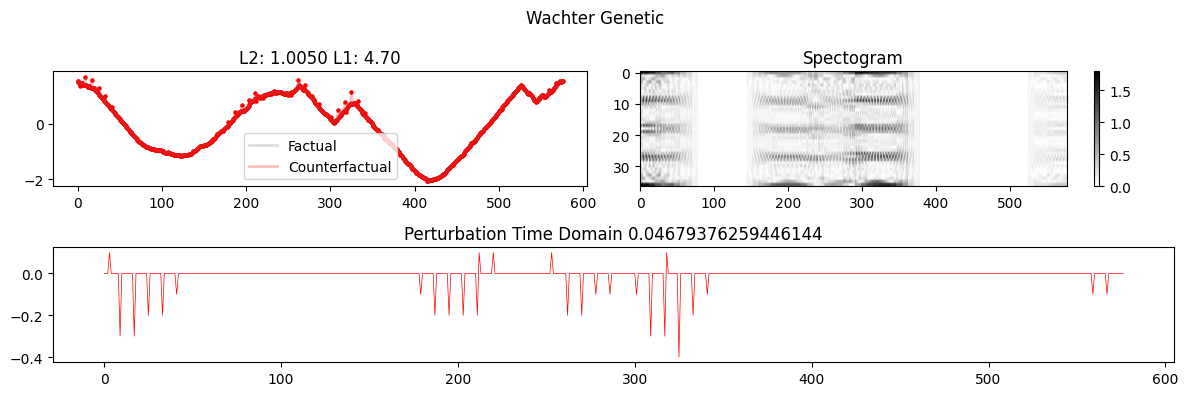

In [501]:
fig = plt.figure(figsize=(12,4))
fig.suptitle("Wachter Genetic")
ax0 = fig.add_subplot(221)
ax0.plot(x.detach().cpu().numpy().flatten(),label='Factual',c='gray',lw=2.0,alpha=0.25)
ax0.plot(cf.flatten(),label='Counterfactual',c='red',lw=2.0,alpha=0.25)
ax0.scatter(np.arange(x.shape[2]),x.detach().cpu().numpy().flatten(),marker='o',color='gray',s=5)
ax0.scatter(np.arange(x.shape[2]),cf.flatten(),marker='o',color='red',s=5)
#ax0.set_title(f"DTW: {cf_gen.sdtw(x_cf,x).detach().cpu().numpy()[0]:.4f}")
ax0.set_title(f"L2: {(np.abs(((cf.flatten()-x.detach().cpu().numpy()))**2).sum())**0.5:.4f} L1: {np.abs(((cf.flatten()-x.detach().cpu().numpy()))).sum():.2f}")
ax0.legend()
ax1 = fig.add_subplot(222)

#ax1.plot(cf['perturbation'].delta_real.detach().cpu().numpy().flatten())
im = ax1.imshow(torch.stft(torch.tensor(x.detach().cpu().numpy().flatten()-cf.flatten()).reshape(1,-1),n_fft=x.shape[2]//8,hop_length=1,return_complex=True).real[0,:,:].detach().abs().cpu().numpy().real,cmap='binary',aspect='auto')
fig.colorbar(im)
ax1.set_title('Spectogram')
#ax1.hist(cf['delta_real'].flatten())
ax2 = fig.add_subplot(212)
ax2.set_title(f'Perturbation Time Domain {((torch.tensor(cf).to(device)!=x).sum()/x.shape[2]).detach().cpu().numpy()}')
ax2.plot(x.detach().cpu().numpy().flatten()-cf.flatten(),color='red',lw=0.5)
# #ax2.set_yscale('log')
print(torch.softmax(clf.model(torch.tensor(cf).reshape(1,1,-1).detach().to(device)),1))
fig.tight_layout()

In [465]:
def spectral_similarity(original_ts: np.ndarray,
                       counterfactual_ts: np.ndarray) -> float:
    """
    Compares frequency domain characteristics of original and counterfactual.
    
    Args:
        original_ts: Original time series data
        counterfactual_ts: Generated counterfactual time series
    
    Returns:
        Spectral similarity score (0 = completely different, 1 = identical)
    """
    if original_ts.ndim > 1:
        orig_flat = original_ts.flatten()
        cf_flat = counterfactual_ts.flatten()
    else:
        orig_flat = original_ts
        cf_flat = counterfactual_ts
    
    # Compute power spectral density
    orig_fft = np.abs(np.fft.fft(orig_flat))
    cf_fft = np.abs(np.fft.fft(cf_flat))
    
    # Normalize
    orig_fft = orig_fft / np.sum(orig_fft)
    cf_fft = cf_fft / np.sum(cf_fft)
    
    # Calculate similarity using correlation
    similarity = np.corrcoef(orig_fft, cf_fft)[0, 1]
    return float(max(0.0, similarity))

In [502]:
spectral_similarity(x.detach().cpu().numpy(),cf)

0.9995347164185807

In [79]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Optional, Tuple, Union, Dict, Any


def comte_cf(
    sample: np.ndarray,
    dataset,
    model: nn.Module,
    target_class: Optional[int] = None,
    lambda_reg: float = 0.01,
    lambda_sparse: float = 0.001,
    learning_rate: float = 0.1,
    max_iterations: int = 3000,
    tolerance: float = 1e-4,
    device: str = None,
    verbose: bool = False
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Generate counterfactual explanation using COMTE algorithm.
    
    Args:
        sample: Original time series sample
        dataset: Dataset object (for compatibility with other methods)
        model: Trained classification model
        target_class: Target class for counterfactual (if None, finds different class)
        lambda_reg: Regularization parameter for proximity constraint
        lambda_sparse: Regularization parameter for sparsity constraint
        learning_rate: Learning rate for optimization
        max_iterations: Maximum number of optimization iterations
        tolerance: Convergence tolerance
        device: Device to run on (if None, auto-detects)
        
    Returns:
        Tuple of (counterfactual_sample, prediction) or (None, None) if failed
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Move model to device and set to eval mode
    model.to(device)
    model.eval()
    
    # Convert sample to tensor and prepare for model
    x_tensor = torch.tensor(sample, dtype=torch.float32, device=device)
    
    # Handle different input shapes - ensure (batch, channels, length)
    if len(x_tensor.shape) == 1:
        x_tensor = x_tensor.reshape(1, 1, -1)  # (length,) -> (1, 1, length)
    elif len(x_tensor.shape) == 2:
        # Could be (channels, length) or (length, channels)
        if x_tensor.shape[0] > x_tensor.shape[1]:
            x_tensor = x_tensor.T  # Assume (length, channels) -> (channels, length)
        x_tensor = x_tensor.unsqueeze(0)  # Add batch dimension
    
    print(x_tensor.shape)
    # Get original prediction
    with torch.no_grad():
        original_pred = model(x_tensor)
        print(original_pred)
        original_class = torch.argmax(original_pred, dim=-1).item()
        original_pred_np = torch.softmax(original_pred, dim=-1).squeeze().cpu().numpy()
    
    # Determine target class
    if target_class is None:
        # Find the class with second highest probability
        sorted_classes = torch.argsort(original_pred, dim=-1, descending=True)
        target_class = sorted_classes[0, 1].item()  # Second most likely class
    
    # If already in target class, return None
    if original_class == target_class:
        return None, None
    
    # Initialize counterfactual as copy of original
    x_cf = x_tensor.clone().detach().requires_grad_(True)
    
    # Optimizer with different strategy
    optimizer = optim.Adam([x_cf], lr=learning_rate)
    
    best_cf = None
    best_loss = float('inf')
    best_validity = 0.0
    
    # Two-phase optimization: first focus on prediction, then refine with regularization
    phase1_iterations = max_iterations // 2
    current_lambda_reg = 0.0  # Start without regularization
    current_lambda_sparse = 0.0
    
    for iteration in range(max_iterations):
        # Switch to phase 2 halfway through - add regularization
        if iteration == phase1_iterations:
            current_lambda_reg = lambda_reg
            current_lambda_sparse = lambda_sparse
            if verbose:
                print(f"COMTE: Switching to phase 2 with regularization at iteration {iteration}")
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(x_cf)
        
        # Prediction loss - focus heavily on getting the right class
        log_probs = torch.log_softmax(logits, dim=-1)
        pred_loss = -log_probs[0, target_class]
        
        # Distance loss (proximity constraint) - only in phase 2
        distance_loss = torch.norm(x_cf - x_tensor, p=2)
        
        # Sparsity loss (encourage minimal changes) - only in phase 2
        sparsity_loss = torch.norm(x_cf - x_tensor, p=1)
        
        # Total loss with adaptive weights
        total_loss = pred_loss + current_lambda_reg * distance_loss + current_lambda_sparse * sparsity_loss
        
        # Backward pass
        total_loss.backward()
        optimizer.step()
        
        # Check current validity
        with torch.no_grad():
            current_probs = torch.softmax(logits, dim=-1)
            current_validity = current_probs[0, target_class].item()
            current_pred_class = torch.argmax(current_probs, dim=-1).item()
        
        # Track best solution (prioritize validity heavily)
        if current_pred_class == target_class:
            if current_validity > best_validity or (current_validity >= best_validity and total_loss.item() < best_loss):
                best_loss = total_loss.item()
                best_validity = current_validity
                best_cf = x_cf.clone().detach()
        elif best_cf is None:
            # If no valid solution yet, keep the one with highest validity
            if current_validity > best_validity:
                best_validity = current_validity
                best_cf = x_cf.clone().detach()
        
                # Early stopping if we've achieved good validity
        if current_validity > 0.99:
            if verbose:
                print(f"COMTE: Early stop at iteration {iteration} with validity {current_validity:.4f}")
            break
        
        # Debug output every 500 iterations
        if verbose and iteration % 500 == 0:
            print(f"COMTE iteration {iteration}: loss={total_loss.item():.4f}, "
                  f"validity={current_validity:.4f}, pred_class={current_pred_class}")
    
    if best_cf is None:
        if verbose:
            print("COMTE: No counterfactual found - best_cf is None")
        return None, None
    
    # Get final prediction
    with torch.no_grad():
        final_pred = model(best_cf)
        predicted_class = torch.argmax(final_pred, dim=-1).item()
        final_pred_np = torch.softmax(final_pred, dim=-1).squeeze().cpu().numpy()
        final_validity = final_pred_np[target_class]
    
    if verbose:
        print(f"COMTE final: pred_class={predicted_class}, target={target_class}, validity={final_validity:.4f}")
    
    # Check if counterfactual is valid - use relaxed criteria
    # Accept if either predicted class matches OR validity is reasonably high
    if predicted_class != target_class and final_validity < 0.4:
        if verbose:
            print(f"COMTE: Counterfactual failed validation - predicted {predicted_class}, wanted {target_class}, validity too low")
        return None, None
    
    # Convert back to original sample format
    cf_sample = best_cf.squeeze(0).cpu().numpy()
    
    # Handle output shape to match input format
    if len(sample.shape) == 1:
        cf_sample = cf_sample.squeeze()  # Remove channel dimension if input was 1D
    elif len(sample.shape) == 2:
        if sample.shape[0] > sample.shape[1]:
            cf_sample = cf_sample.T  # Convert back to (length, channels) if needed
    
    return cf_sample, final_pred_np


def _compute_distance(x1: torch.Tensor, x2: torch.Tensor, metric: str = 'euclidean') -> torch.Tensor:
    """Compute distance between two time series."""
    if metric == 'euclidean':
        return torch.norm(x1 - x2, p=2)
    elif metric == 'dtw':
        return _soft_dtw(x1, x2)
    else:
        raise ValueError(f"Unsupported distance metric: {metric}")


def _soft_dtw(x1: torch.Tensor, x2: torch.Tensor, gamma: float = 1.0) -> torch.Tensor:
    """
    Simplified soft DTW implementation for differentiable DTW computation.
    """
    # Flatten to 1D for DTW computation
    if len(x1.shape) > 1:
        x1_flat = x1.flatten()
        x2_flat = x2.flatten()
    else:
        x1_flat = x1
        x2_flat = x2
    
    n, m = len(x1_flat), len(x2_flat)
    
    # Compute pairwise squared distances
    D = torch.zeros(n, m, device=x1.device)
    for i in range(n):
        for j in range(m):
            D[i, j] = (x1_flat[i] - x2_flat[j]) ** 2
    
    # Initialize DP matrix
    R = torch.full((n + 1, m + 1), float('inf'), device=x1.device)
    R[0, 0] = 0
    
    # Fill DP matrix with soft-min approximation
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            r0 = R[i-1, j-1]
            r1 = R[i-1, j]
            r2 = R[i, j-1]
            
            # Simple minimum for differentiability
            R[i, j] = D[i-1, j-1] + torch.min(torch.stack([r0, r1, r2]))
    
    return R[n, m]


# Alternative function with more configuration options
def comte_cf_advanced(
    sample: np.ndarray,
    dataset,
    model: nn.Module,
    target_class: Optional[int] = None,
    distance_metric: str = 'euclidean',
    lambda_reg: float = 1.0,
    lambda_sparse: float = 0.1,
    learning_rate: float = 0.01,
    max_iterations: int = 1000,
    tolerance: float = 1e-6,
    constraints: Optional[Dict[str, Any]] = None,
    device: str = None
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Advanced COMTE implementation with additional options.
    
    Additional Args:
        distance_metric: Distance metric ('euclidean' or 'dtw')
        constraints: Dictionary of constraints (e.g., feature bounds)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    model.eval()
    
    # Prepare input tensor
    x_tensor = torch.tensor(sample, dtype=torch.float32, device=device)
    if len(x_tensor.shape) == 1:
        x_tensor = x_tensor.reshape(1, 1, -1)
    elif len(x_tensor.shape) == 2:
        if x_tensor.shape[0] > x_tensor.shape[1]:
            x_tensor = x_tensor.T
        x_tensor = x_tensor.unsqueeze(0)
    
    # Get original prediction and determine target
    with torch.no_grad():
        original_pred = model(x_tensor)
        original_class = torch.argmax(original_pred, dim=-1).item()
    
    if target_class is None:
        sorted_classes = torch.argsort(original_pred, dim=-1, descending=True)
        target_class = sorted_classes[0, 1].item()
    
    if original_class == target_class:
        return None, None
    
    # Initialize and optimize
    x_cf = x_tensor.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([x_cf], lr=learning_rate)
    
    best_cf = None
    best_loss = float('inf')
    prev_loss = float('inf')
    
    for iteration in range(max_iterations):
        optimizer.zero_grad()
        
        # Compute losses
        logits = model(x_cf)
        log_probs = torch.log_softmax(logits, dim=-1)
        pred_loss = -log_probs[0, target_class]
        
        distance_loss = _compute_distance(x_cf, x_tensor, distance_metric)
        sparsity_loss = torch.norm(x_cf - x_tensor, p=1)
        
        total_loss = pred_loss + lambda_reg * distance_loss + lambda_sparse * sparsity_loss
        
        total_loss.backward()
        optimizer.step()
        
        # Apply constraints if provided
        if constraints:
            _apply_constraints(x_cf, constraints)
        
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_cf = x_cf.clone().detach()
        
        if iteration > 0 and abs(prev_loss - total_loss.item()) < tolerance:
            break
        
        prev_loss = total_loss.item()
    
    if best_cf is None:
        return None, None
    
    # Verify and return
    with torch.no_grad():
        final_pred = model(best_cf)
        predicted_class = torch.argmax(final_pred, dim=-1).item()
        final_pred_np = torch.softmax(final_pred, dim=-1).squeeze().cpu().numpy()
    
    if predicted_class != target_class:
        return None, None
    
    # Format output
    cf_sample = best_cf.squeeze(0).cpu().numpy()
    if len(sample.shape) == 1:
        cf_sample = cf_sample.squeeze()
    elif len(sample.shape) == 2 and sample.shape[0] > sample.shape[1]:
        cf_sample = cf_sample.T
    
    return cf_sample, final_pred_np


def _apply_constraints(x_cf: torch.Tensor, constraints: Dict[str, Any]):
    """Apply constraints during optimization."""
    with torch.no_grad():
        if 'feature_bounds' in constraints:
            bounds = constraints['feature_bounds']
            for i, (min_val, max_val) in enumerate(bounds):
                if i < x_cf.shape[1]:  # Check if feature index exists
                    x_cf[0, i, :] = torch.clamp(x_cf[0, i, :], min_val, max_val)
        
        if 'immutable_features' in constraints:
            # This would need the original tensor to restore immutable features
            pass  # Simplified for this implementation


def comte_ts_cf(
    sample: np.ndarray,
    dataset,
    model: nn.Module,
    target_class: Optional[int] = None,
    lambda_reg: float = 0.01,
    lambda_sparse: float = 0.001,
    lambda_smooth: float = 0.01,
    lambda_temporal: float = 0.005,
    learning_rate: float = 0.1,
    max_iterations: int = 3000,
    tolerance: float = 1e-4,
    device: str = None,
    verbose: bool = False
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    """
    CoMTE-TS: CoMTE for Time Series with temporal consistency constraints.
    
    CoMTE-TS extends the original CoMTE algorithm with additional regularization
    terms specifically designed for time series data:
    - Temporal smoothness: Encourages gradual changes over time
    - Trend preservation: Maintains local temporal trends
    - Pattern consistency: Preserves important temporal patterns
    
    Args:
        sample: Original time series sample
        dataset: Dataset object (for compatibility)
        model: Trained classification model
        target_class: Target class for counterfactual
        lambda_reg: Proximity constraint weight
        lambda_sparse: Sparsity constraint weight
        lambda_smooth: Temporal smoothness weight (penalizes rapid changes)
        lambda_temporal: Temporal consistency weight (preserves trends)
        learning_rate: Learning rate for optimization
        max_iterations: Maximum optimization iterations
        tolerance: Convergence tolerance
        device: Device to run on
        verbose: Print debug information
        
    Returns:
        Tuple of (counterfactual_sample, prediction) or (None, None) if failed
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Move model to device and set to eval mode
    model.to(device)
    model.eval()
    
    # Convert sample to tensor and prepare for model
    x_tensor = torch.tensor(sample, dtype=torch.float32, device=device)
    original_shape = sample.shape
    print(original_shape)
    
    # Handle different input shapes - ensure (batch, channels, length)
    if len(x_tensor.shape) == 1:
        x_tensor = x_tensor.reshape(1, 1, -1)
    elif len(x_tensor.shape) == 2:
        if x_tensor.shape[0] > x_tensor.shape[1]:
            x_tensor = x_tensor.T
        x_tensor = x_tensor.unsqueeze(0)
    
    B, C, L = x_tensor.shape
    
    
    # Get original prediction
    with torch.no_grad():
        original_pred = model(x_tensor)
        original_class = torch.argmax(original_pred, dim=-1).item()
        original_pred_np = torch.softmax(original_pred, dim=-1).squeeze().cpu().numpy()
    
    # Determine target class
    if target_class is None:
        sorted_classes = torch.argsort(original_pred, dim=-1, descending=True)
        target_class = sorted_classes[0, 1].item()
    
    if original_class == target_class:
        return None, None
    
    # Compute original temporal properties for preservation
    with torch.no_grad():
        # First-order differences (velocity)
        original_diff1 = x_tensor[:, :, 1:] - x_tensor[:, :, :-1]
        # Second-order differences (acceleration)
        original_diff2 = original_diff1[:, :, 1:] - original_diff1[:, :, :-1]
    
    # Initialize counterfactual
    x_cf = x_tensor.clone().detach().requires_grad_(True)
    optimizer = optim.Adam([x_cf], lr=learning_rate)
    
    best_cf = None
    best_loss = float('inf')
    best_validity = 0.0
    
    # Adaptive regularization: start with prediction focus, add constraints later
    phase1_iterations = max_iterations // 3
    phase2_iterations = 2 * max_iterations // 3
    
    for iteration in range(max_iterations):
        # Adjust regularization weights progressively
        if iteration < phase1_iterations:
            # Phase 1: Focus on prediction
            curr_lambda_reg = 0.0
            curr_lambda_sparse = 0.0
            curr_lambda_smooth = 0.0
            curr_lambda_temporal = 0.0
        elif iteration < phase2_iterations:
            # Phase 2: Add proximity and smoothness
            curr_lambda_reg = lambda_reg * 0.5
            curr_lambda_sparse = lambda_sparse * 0.5
            curr_lambda_smooth = lambda_smooth
            curr_lambda_temporal = lambda_temporal * 0.5
        else:
            # Phase 3: Full regularization
            curr_lambda_reg = lambda_reg
            curr_lambda_sparse = lambda_sparse
            curr_lambda_smooth = lambda_smooth
            curr_lambda_temporal = lambda_temporal
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(x_cf)
        log_probs = torch.log_softmax(logits, dim=-1)
        pred_loss = -log_probs[0, target_class]
        
        # Proximity loss (L2 distance)
        distance_loss = torch.norm(x_cf - x_tensor, p=2)
        
        # Sparsity loss (L1 distance)
        sparsity_loss = torch.norm(x_cf - x_tensor, p=1)
        
        # Temporal smoothness loss: penalize large changes between consecutive time points
        cf_diff1 = x_cf[:, :, 1:] - x_cf[:, :, :-1]
        smoothness_loss = torch.norm(cf_diff1, p=2)
        
        # Temporal consistency: preserve local trends (second-order smoothness)
        cf_diff2 = cf_diff1[:, :, 1:] - cf_diff1[:, :, :-1]
        temporal_loss = torch.norm(cf_diff2 - original_diff2, p=2)
        
        # Total loss
        total_loss = (pred_loss + 
                     curr_lambda_reg * distance_loss + 
                     curr_lambda_sparse * sparsity_loss +
                     curr_lambda_smooth * smoothness_loss +
                     curr_lambda_temporal * temporal_loss)
        
        # Backward pass
        total_loss.backward()
        optimizer.step()
        
        # Evaluate current solution
        with torch.no_grad():
            current_probs = torch.softmax(logits, dim=-1)
            current_validity = current_probs[0, target_class].item()
            current_pred_class = torch.argmax(current_probs, dim=-1).item()
        
        # Track best solution
        if current_pred_class == target_class:
            if current_validity > best_validity or \
               (current_validity >= best_validity and total_loss.item() < best_loss):
                best_loss = total_loss.item()
                best_validity = current_validity
                best_cf = x_cf.clone().detach()
        elif best_cf is None or current_validity > best_validity:
            best_validity = current_validity
            best_cf = x_cf.clone().detach()
        
        # Early stopping
        if current_validity > 0.99 and current_pred_class == target_class:
            if verbose:
                print(f"CoMTE-TS: Early stop at iteration {iteration} with validity {current_validity:.4f}")
            break
        
        # Debug output
        if verbose and iteration % 500 == 0:
            print(f"CoMTE-TS iter {iteration}: loss={total_loss.item():.4f}, "
                  f"pred={pred_loss.item():.4f}, smooth={smoothness_loss.item():.4f}, "
                  f"validity={current_validity:.4f}, pred_class={current_pred_class}")
    
    if best_cf is None:
        if verbose:
            print("CoMTE-TS: No counterfactual found")
        return None, None
    
    # Get final prediction
    with torch.no_grad():
        final_pred = model(best_cf)
        predicted_class = torch.argmax(final_pred, dim=-1).item()
        final_pred_np = torch.softmax(final_pred, dim=-1).squeeze().cpu().numpy()
        final_validity = final_pred_np[target_class]
    
    if verbose:
        print(f"CoMTE-TS final: pred_class={predicted_class}, target={target_class}, "
              f"validity={final_validity:.4f}")
    
    # Relaxed validation
    if predicted_class != target_class and final_validity < 0.3:
        if verbose:
            print("CoMTE-TS: Counterfactual failed validation")
        return None, None
    
    # Convert back to original format
    cf_sample = best_cf.squeeze(0).cpu().numpy()
    
    if len(original_shape) == 1:
        cf_sample = cf_sample.squeeze()
    elif len(original_shape) == 2:
        if original_shape[0] > original_shape[1]:
            cf_sample = cf_sample.T
    
    return cf_sample, final_pred_np


In [483]:
cf, prediction = comte_ts_cf(x, model=clf.model,dataset=None,lambda_sparse=0.0050,lambda_reg=0.0050)
#torch.tensor(x.detach().cpu().numpy().flatten()-cf.flatten()).reshape(1,-1)

torch.Size([1, 1, 24])


tensor([[0.9904, 0.0096]], device='cuda:0')


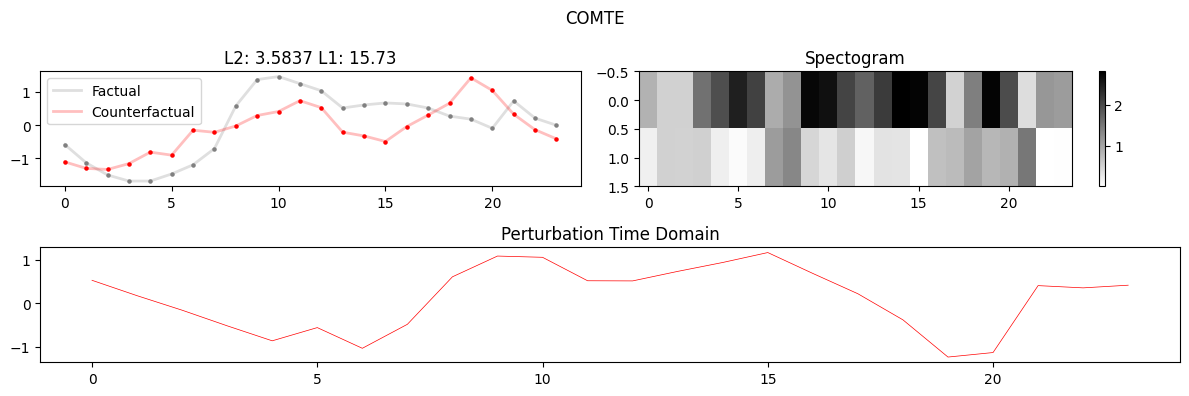

In [484]:
fig = plt.figure(figsize=(12,4))
fig.suptitle("COMTE")
ax0 = fig.add_subplot(221)
ax0.plot(x.detach().cpu().numpy().flatten(),label='Factual',c='gray',lw=2.0,alpha=0.25)
ax0.plot(cf.flatten(),label='Counterfactual',c='red',lw=2.0,alpha=0.25)
ax0.scatter(np.arange(x.shape[2]),x.detach().cpu().numpy().flatten(),marker='o',color='gray',s=5)
ax0.scatter(np.arange(x.shape[2]),cf.flatten(),marker='o',color='red',s=5)
#ax0.set_title(f"DTW: {cf_gen.sdtw(x_cf,x).detach().cpu().numpy()[0]:.4f}")
#ax0.set_title(f"DTW: {(np.abs(((cf.flatten()-x.detach().cpu().numpy()))**2).sum())**0.5:.4f}")
ax0.set_title(f"L2: {(np.abs(((cf.flatten()-x.detach().cpu().numpy()))**2).sum())**0.5:.4f} L1: {np.abs(((cf.flatten()-x.detach().cpu().numpy()))).sum():.2f}")
ax0.legend()
ax1 = fig.add_subplot(222)

#ax1.plot(cf['perturbation'].delta_real.detach().cpu().numpy().flatten())
im = ax1.imshow(torch.stft(torch.tensor(x.detach().cpu().numpy().flatten()-cf.flatten()).reshape(1,-1),n_fft=x.shape[2]//8,hop_length=1,return_complex=True).real[0,:,:].detach().abs().cpu().numpy().real,cmap='binary',aspect='auto')
fig.colorbar(im)
ax1.set_title('Spectogram')
#ax1.hist(cf['delta_real'].flatten())
ax2 = fig.add_subplot(212)
ax2.set_title(f'Perturbation Time Domain')
ax2.plot(x.detach().cpu().numpy().flatten()-cf.flatten(),color='red',lw=0.5)
# #ax2.set_yscale('log')
print(torch.softmax(clf.model(torch.tensor(cf.reshape(1,1,-1)).to(device)),1))
fig.tight_layout()

In [117]:
import torch

import numpy as np

from captum.attr import GradientShap

from sklearn.neighbors import NearestNeighbors


def detach_to_numpy(data):
    # move pytorch data to cpu and detach it to numpy data
    return data.cpu().detach().numpy()


def numpy_to_torch(data, device):
    # convert numpy array to pytorch and move it to the device
    return torch.from_numpy(data).float().to(device)


####
# Instance-based Counterfactual Explanations for Time Series Classification
# (paper reference omitted for brevity)
####
def _ensure_ncl(sample, dataset):
    """Ensure sample and dataset are shaped (C, L) and (N, C, L) respectively.

    Heuristic: for 2D arrays, if rows <= cols treat as (C, L), else treat as
    (L, C) and transpose. This lets us cheaply detect already (N, C, L).
    """
    # normalize sample to (C, L)
    s = np.asarray(sample)
    if s.ndim == 1:
        s_ncl = s.reshape(1, -1)
        ori = "1d"
    elif s.ndim == 2:
        r, c = s.shape
        if r <= c:
            s_ncl = s.copy()
            ori = "cf"
        else:
            s_ncl = s.T.copy()
            ori = "tf"
    else:
        raise ValueError("sample must be 1D or 2D time series")

    # build time_series_data as (N, C, L) with a single vectorized pass
    # dataset is expected to yield (x, y) tuples; take only x
    first = dataset[0][0]
    first_arr = np.asarray(first)
    # If first is already (N, C, L) (i.e., dataset provided as array), try to use it
    if first_arr.ndim == 3 and isinstance(dataset, np.ndarray):
        ts = np.asarray([x for x in dataset[:, 0]])
    else:
        # check orientation using the first element
        fa = first_arr
        if fa.ndim == 1:
            # each item is (L,) -> produce (N, 1, L)
            ts = np.stack([np.asarray(x[0]).reshape(1, -1) for x in dataset], axis=0)
        elif fa.ndim == 2:
            r, c = fa.shape
            if r <= c:
                # assume (C, L) already
                ts = np.stack([np.asarray(x[0]) for x in dataset], axis=0)
            else:
                # assume (L, C) and transpose each
                ts = np.stack([np.asarray(x[0]).T for x in dataset], axis=0)
        else:
            raise ValueError("dataset items must be 1D or 2D time series")

    # ensure same length as sample
    _, L = s_ncl.shape
    if ts.shape[-1] != L:
        raise ValueError("All series must have same length as sample")

    # if channel mismatch and dataset is single-channel, broadcast it
    C_sample = s_ncl.shape[0]
    C_data = ts.shape[1]
    if C_data != C_sample:
        if C_data == 1:
            ts = np.repeat(ts, C_sample, axis=1)
        else:
            raise ValueError("Channel count mismatch between sample and dataset")

    return s_ncl, ts, ori


def native_guide_uni_cf(sample, dataset, model, weight_function=GradientShap, iterate=None, sub_len=1, verbose=False):
    """Native Guide counterfactual supporting multivariate inputs.

    Returns counterfactual in same orientation as input sample, plus model scores.
    """
    device = next(model.parameters()).device

    def model_predict(arr):
        # arr expected shape (B, C, L)
        return detach_to_numpy(model(numpy_to_torch(arr, device)))

    # prepare sample and dataset in (C, L) and (N, C, L)
    sample_cf, time_series_data, sample_ori = _ensure_ncl(sample, dataset)
    N, C, L = time_series_data.shape

    if iterate is None:
        iterate = L

    # get predictions
    preds_data = model_predict(time_series_data)
    preds_sample = model_predict(sample_cf.reshape(1, C, L))
    label_data = np.argmax(preds_data, axis=1)
    label_sample = int(np.argmax(preds_sample))

    # select candidates with different label
    mask = label_data != label_sample
    if not np.any(mask):
        return (_revert_orientation if ' _revert_orientation' in globals() else _simple_revert)(sample_cf, sample_ori), preds_sample.reshape(-1)

    candidates = time_series_data[mask]
    candidates_labels = label_data[mask]

    # choose k neighbors (at least 1)
    k_for_candidates = max(1, min(int(L * 0.25), len(candidates)))
    neigh = NearestNeighbors(n_neighbors=min(k_for_candidates + 1, len(candidates)), metric="euclidean")
    neigh.fit(candidates.reshape(len(candidates), -1))
    dists, idxs = neigh.kneighbors(sample_cf.reshape(1, -1), return_distance=True)

    native_guide = None
    cf_label = None
    # find first neighbor with different class (skip exact matches)
    for idx in idxs[0]:
        if candidates_labels[idx] != label_sample:
            native_guide = candidates[idx]
            cf_label = int(candidates_labels[idx])
            break
    if native_guide is None:
        native_guide = candidates[0]
        cf_label = int(candidates_labels[0])

    # compute attributions using provided weight_function
    weights = weight_function(model)
    baselines = numpy_to_torch(time_series_data, device)
    attributions = weights.attribute(numpy_to_torch(native_guide.reshape(1, C, L), device),
                                     baselines=baselines,
                                     target=int(cf_label))
    attr_np = detach_to_numpy(attributions)
    # attr_np shape (1, C, L) typically
    if attr_np.ndim == 3:
        importance = np.sum(np.abs(attr_np[0]), axis=0)  # (L,)
    else:
        importance = np.sum(np.abs(attr_np), axis=0)

    # sliding-window sum to get most influential window start
    def find_most_influential_array(length):
        if length >= len(importance):
            return 0
        conv = np.convolve(importance, np.ones(length, dtype=importance.dtype), mode="valid")
        return int(np.argmax(conv))

    # iterative replacement
    cf_cf = sample_cf.copy()
    y_cf = preds_sample.reshape(-1)
    for i in range(iterate):
        length = i + sub_len
        if length > L:
            break
        start = find_most_influential_array(length)
        end = start + length
        cf_candidate = cf_cf.copy()
        cf_candidate[:, start:end] = native_guide[:, start:end]
        y_candidate = model_predict(cf_candidate.reshape(1, C, L)).reshape(-1)
        cf_cf = cf_candidate
        y_cf = y_candidate
        if cf_label == int(np.argmax(y_cf)):
            break

    # revert to original orientation
    cf_out = _revert_orientation(cf_cf, sample_ori) if ' _revert_orientation' in globals() else _simple_revert(cf_cf, sample_ori)
    return cf_out, y_cf


# simple revert used if helper not present in older file versions
def _simple_revert(cf_arr, orientation):
    if orientation == "1d":
        return cf_arr.reshape(-1)
    if orientation == "cf":
        return cf_arr
    if orientation == "tf":
        return cf_arr.T
    return cf_arr


def _revert_orientation(cf_arr, orientation):
    return _simple_revert(cf_arr, orientation)



tensor([[0.5449, 0.4551]], device='cuda:0')


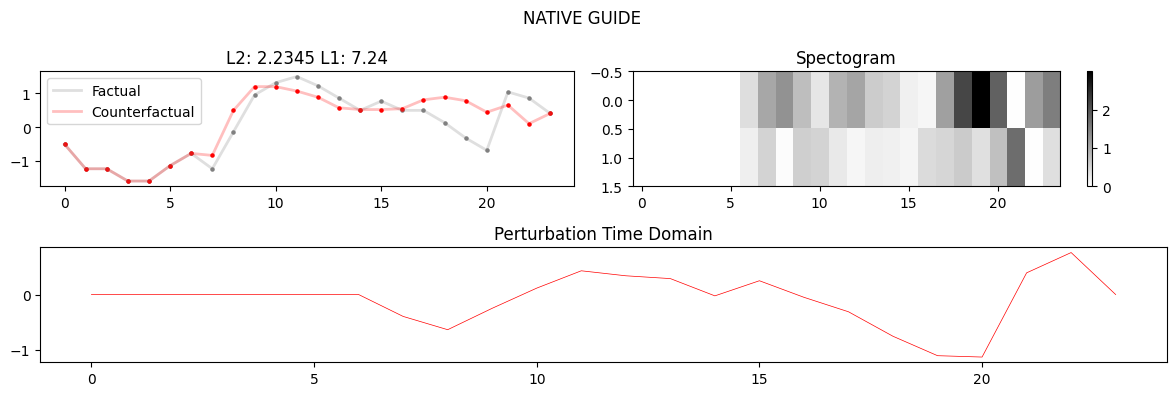

In [393]:
dataset = np.array(X.tolist())
cf, pred  = native_guide_uni_cf(x.detach().cpu().numpy()[0,:,:],dataset=dataset,model=clf.model)

fig = plt.figure(figsize=(12,4))
fig.suptitle("NATIVE GUIDE")
ax0 = fig.add_subplot(221)
ax0.plot(x.detach().cpu().numpy().flatten(),label='Factual',c='gray',lw=2.0,alpha=0.25)
ax0.plot(cf.flatten(),label='Counterfactual',c='red',lw=2.0,alpha=0.25)
ax0.scatter(np.arange(x.shape[2]),x.detach().cpu().numpy().flatten(),marker='o',color='gray',s=5)
ax0.scatter(np.arange(x.shape[2]),cf.flatten(),marker='o',color='red',s=5)
#ax0.set_title(f"DTW: {cf_gen.sdtw(x_cf,x).detach().cpu().numpy()[0]:.4f}")
#ax0.set_title(f"DTW: {(np.abs(((cf.flatten()-x.detach().cpu().numpy()))**2).sum())**0.5:.4f}")
ax0.set_title(f"L2: {(np.abs(((cf.flatten()-x.detach().cpu().numpy()))**2).sum())**0.5:.4f} L1: {np.abs(((cf.flatten()-x.detach().cpu().numpy()))).sum():.2f}")

ax0.legend()
ax1 = fig.add_subplot(222)

#ax1.plot(cf['perturbation'].delta_real.detach().cpu().numpy().flatten())
im = ax1.imshow(torch.stft(torch.tensor(torch.tensor(x.detach().cpu().numpy().flatten()-cf.flatten()).reshape(1,-1)),n_fft=x.shape[2]//8,hop_length=1,return_complex=True).real[0,:,:].detach().abs().cpu().numpy().real,cmap='binary',aspect='auto')
fig.colorbar(im)
ax1.set_title('Spectogram')
#ax1.hist(cf['delta_real'].flatten())
ax2 = fig.add_subplot(212)
ax2.set_title(f'Perturbation Time Domain')
ax2.plot(x.detach().cpu().numpy().flatten()-cf.flatten(),color='red',lw=0.5)
# #ax2.set_yscale('log')
#print(torch.softmax(clf.model(cf.detach().to(device)),1))
print(torch.softmax(clf.model(torch.tensor(cf.reshape(1,1,-1)).to(device)),1))

fig.tight_layout()

In [50]:
import torch
import numpy as np
import copy
from captum.attr import GradientShap


def detach_to_numpy(data):
    """Move pytorch data to cpu and detach it to numpy data."""
    return data.cpu().detach().numpy()


def numpy_to_torch(data, device):
    """Convert numpy array to pytorch and move it to the device."""
    return torch.from_numpy(data).float().to(device)


def _ensure_ncl(sample, dataset):
    """Ensure sample and dataset are shaped (C, L) and (N, C, L) respectively.
    
    Heuristic: for 2D arrays, if rows <= cols treat as (C, L), else treat as
    (L, C) and transpose. This lets us cheaply detect already (N, C, L).
    """
    # normalize sample to (C, L)
    s = np.asarray(sample)
    if s.ndim == 1:
        s_ncl = s.reshape(1, -1)
        ori = "1d"
    elif s.ndim == 2:
        r, c = s.shape
        if r <= c:
            s_ncl = s.copy()
            ori = "cf"
        else:
            s_ncl = s.T.copy()
            ori = "tf"
    else:
        raise ValueError("sample must be 1D or 2D time series")

    # build time_series_data as (N, C, L) with a single vectorized pass
    first = dataset[0][0]
    first_arr = np.asarray(first)
    if first_arr.ndim == 3 and isinstance(dataset, np.ndarray):
        ts = np.asarray([x for x in dataset[:, 0]])
    else:
        fa = first_arr
        if fa.ndim == 1:
            ts = np.stack([np.asarray(x[0]).reshape(1, -1) for x in dataset], axis=0)
        elif fa.ndim == 2:
            r, c = fa.shape
            if r <= c:
                ts = np.stack([np.asarray(x[0]) for x in dataset], axis=0)
            else:
                ts = np.stack([np.asarray(x[0]).T for x in dataset], axis=0)
        else:
            raise ValueError("dataset items must be 1D or 2D time series")

    _, L = s_ncl.shape
    if ts.shape[-1] != L:
        raise ValueError("All series must have same length as sample")

    C_sample = s_ncl.shape[0]
    C_data = ts.shape[1]
    if C_data != C_sample:
        if C_data == 1:
            ts = np.repeat(ts, C_sample, axis=1)
        else:
            raise ValueError("Channel count mismatch between sample and dataset")

    return s_ncl, ts, ori


def _revert_orientation(cf_arr, orientation):
    """Revert counterfactual to original orientation."""
    if orientation == "1d":
        return cf_arr.reshape(-1)
    if orientation == "cf":
        return cf_arr
    if orientation == "tf":
        return cf_arr.T
    return cf_arr


def calculate_feature_importance(model, sample, dataset, device):
    """Calculate feature importance using GradientShap.
    
    Args:
        model: PyTorch model
        sample: Sample to explain (C, L)
        dataset: Training dataset for baselines
        device: Device to run on
        
    Returns:
        importance: Feature importance scores (C, L)
    """
    weights = GradientShap(model)
    sample_tensor = numpy_to_torch(sample.reshape(1, sample.shape[0], sample.shape[1]), device)
    
    # Use subset of training data as baselines
    n_baselines = min(50, len(dataset))
    baseline_indices = np.random.choice(len(dataset), n_baselines, replace=False)
    baselines_list = []
    for idx in baseline_indices:
        item = dataset[idx][0]
        if isinstance(item, np.ndarray):
            baselines_list.append(item)
        else:
            baselines_list.append(np.asarray(item))
    
    baselines = np.stack(baselines_list, axis=0)
    if baselines.ndim == 2:
        baselines = baselines.reshape(n_baselines, 1, -1)
    elif baselines.ndim == 3 and baselines.shape[1] > baselines.shape[2]:
        baselines = np.transpose(baselines, (0, 2, 1))
    
    baselines_tensor = numpy_to_torch(baselines, device)
    
    # Get prediction for target class
    pred = model(sample_tensor)
    target_class = int(torch.argmax(pred, dim=1)[0])
    
    attributions = weights.attribute(sample_tensor, baselines=baselines_tensor, target=target_class)
    attr_np = detach_to_numpy(attributions)
    
    if attr_np.ndim == 3:
        importance = np.abs(attr_np[0])  # (C, L)
    else:
        importance = np.abs(attr_np)
    
    return importance


def multi_space_cf(sample, dataset, model, weight_function=GradientShap, 
                   iterate=None, sub_len=1, population_size=50, max_iterations=100,
                   sparsity_weight=0.3, validity_weight=0.7, verbose=False):
    """Multi-SpaCE counterfactual generation with multi-objective optimization.
    
    This is a simplified implementation of Multi-SpaCE that uses:
    - Feature importance for initialization
    - Subsequence-based optimization
    - Multi-objective fitness (validity, sparsity, plausibility)
    
    Args:
        sample: Input time series
        dataset: Training dataset
        model: Classifier model
        weight_function: Attribution method (default GradientShap)
        iterate: Number of iterations (default: sequence length)
        sub_len: Starting subsequence length
        population_size: Number of candidates to maintain
        max_iterations: Maximum optimization iterations
        sparsity_weight: Weight for sparsity objective
        validity_weight: Weight for validity objective
        
    Returns:
        cf: Counterfactual explanation
        y_cf: Prediction probabilities
    """
    device = next(model.parameters()).device

    def model_predict(arr):
        # arr expected shape (B, C, L)
        return detach_to_numpy(model(numpy_to_torch(arr, device)))

    # Prepare sample and dataset in (C, L) and (N, C, L)
    sample_cf, time_series_data, sample_ori = _ensure_ncl(sample, dataset)
    N, C, L = time_series_data.shape

    if iterate is None:
        iterate = L

    # Get predictions
    preds_data = model_predict(time_series_data)
    preds_sample = model_predict(sample_cf.reshape(1, C, L))
    label_data = np.argmax(preds_data, axis=1)
    label_sample = int(np.argmax(preds_sample))

    # Select candidates with different label
    mask = label_data != label_sample
    if not np.any(mask):
        return _revert_orientation(sample_cf, sample_ori), preds_sample.reshape(-1)

    candidates = time_series_data[mask]
    candidates_labels = label_data[mask]

    # Find native guide (nearest unlike neighbor - NUN)
    distances = np.sum((candidates.reshape(len(candidates), -1) - sample_cf.reshape(1, -1))**2, axis=1)
    nun_idx = np.argmin(distances)
    native_guide = candidates[nun_idx]
    cf_label = int(candidates_labels[nun_idx])

    # Calculate feature importance for both sample and NUN
    importance_sample = calculate_feature_importance(model, sample_cf, dataset, device)
    importance_nun = calculate_feature_importance(model, native_guide.reshape(C, L), dataset, device)
    
    # Combined importance heatmap
    combined_importance = (importance_sample + importance_nun) / 2
    
    # Sum over channels to get time importance
    time_importance = np.sum(combined_importance, axis=0)  # (L,)
    
    # Initialize population of masks (which subsequences to replace)
    # Use feature importance to guide initialization
    population = []
    
    for _ in range(population_size):
        # Create binary mask indicating which positions to replace
        mask_cf = np.zeros((C, L), dtype=bool)
        
        # Start with most important regions
        n_points = np.random.randint(1, max(2, L // 4))
        
        # Select positions based on importance
        probs = time_importance / (time_importance.sum() + 1e-10)
        selected_positions = np.random.choice(L, size=min(n_points, L), 
                                             replace=False, p=probs)
        
        # Create subsequences around selected positions
        for pos in selected_positions:
            subseq_len = np.random.randint(1, min(sub_len + 5, L // 2))
            start = max(0, pos - subseq_len // 2)
            end = min(L, start + subseq_len)
            mask_cf[:, start:end] = True
        
        population.append(mask_cf)
    
    population = np.array(population)
    
    # Evolutionary optimization
    best_cf = sample_cf.copy()
    best_fitness = -np.inf
    best_probs = preds_sample.reshape(-1)
    
    for iteration in range(max_iterations):
        # Generate counterfactuals from population
        cfs = np.zeros((population_size, C, L))
        for i, mask in enumerate(population):
            cf_candidate = sample_cf.copy()
            cf_candidate[mask] = native_guide[mask]
            cfs[i] = cf_candidate
        
        # Evaluate fitness
        preds = model_predict(cfs)
        
        # Multi-objective fitness
        validity = preds[:, cf_label]  # Probability of target class
        sparsity = 1.0 - (population.sum(axis=(1, 2)) / (C * L))  # Fewer changes is better
        
        # Count subsequences (fewer is better)
        n_subsequences = np.zeros(population_size)
        for i, mask in enumerate(population):
            # Count transitions in each channel
            for c in range(C):
                transitions = np.diff(mask[c].astype(int), prepend=0)
                n_subsequences[i] += np.sum(transitions == 1)
        
        # Normalize subsequences
        max_subseq = max(n_subsequences.max(), 1)
        subsequence_score = 1.0 - (n_subsequences / max_subseq)
        
        # Combined fitness
        fitness = (validity_weight * validity + 
                  sparsity_weight * sparsity * 0.5 + 
                  sparsity_weight * subsequence_score * 0.5)
        
        # Check for valid counterfactuals
        valid_indices = np.where(np.argmax(preds, axis=1) == cf_label)[0]
        
        if len(valid_indices) > 0:
            # Among valid ones, select sparsest
            valid_fitness = sparsity[valid_indices] + subsequence_score[valid_indices]
            best_valid_idx = valid_indices[np.argmax(valid_fitness)]
            
            if fitness[best_valid_idx] > best_fitness:
                best_fitness = fitness[best_valid_idx]
                best_cf = cfs[best_valid_idx]
                best_probs = preds[best_valid_idx]
                
            # If we found a good valid CF, we can stop early
            if sparsity[best_valid_idx] > 0.7:  # 70% unchanged
                break
        
        # Update best overall if better
        best_idx = np.argmax(fitness)
        if fitness[best_idx] > best_fitness:
            best_fitness = fitness[best_idx]
            best_cf = cfs[best_idx]
            best_probs = preds[best_idx]
        
        # Selection and mutation for next generation
        if iteration < max_iterations - 1:
            # Select elite individuals
            elite_size = max(2, population_size // 10)
            elite_indices = np.argsort(fitness)[-elite_size:]
            new_population = [population[i].copy() for i in elite_indices]
            
            # Generate offspring through mutation
            while len(new_population) < population_size:
                # Select parent
                parent_idx = np.random.choice(elite_indices)
                child = population[parent_idx].copy()
                
                # Mutation: flip some positions
                mutation_rate = 0.05
                for c in range(C):
                    for t in range(L):
                        if np.random.random() < mutation_rate:
                            child[c, t] = not child[c, t]
                
                # Mutation: add/remove subsequence
                if np.random.random() < 0.3:
                    subseq_len = np.random.randint(1, L // 4)
                    start = np.random.randint(0, L - subseq_len)
                    if np.random.random() < 0.5:
                        # Add subsequence
                        child[:, start:start + subseq_len] = True
                    else:
                        # Remove subsequence
                        child[:, start:start + subseq_len] = False
                
                new_population.append(child)
            
            population = np.array(new_population[:population_size])
    
    # Revert to original orientation
    cf_out = _revert_orientation(best_cf, sample_ori)
    return cf_out, best_probs


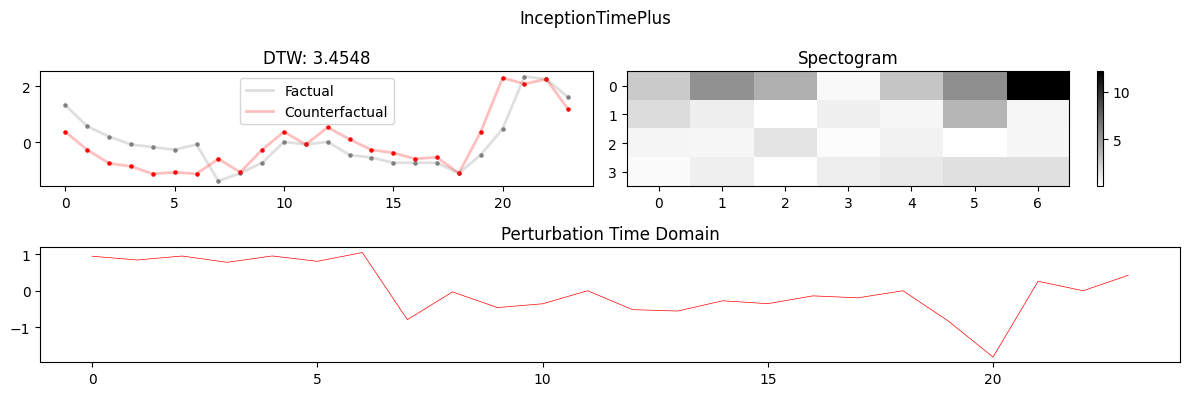

In [51]:
cf , prediction = multi_space_cf(x.detach().cpu().numpy()[0,:,:],dataset=dataset,model=clf.model)

fig = plt.figure(figsize=(12,4))
fig.suptitle(model_name)
ax0 = fig.add_subplot(221)
ax0.plot(x.detach().cpu().numpy().flatten(),label='Factual',c='gray',lw=2.0,alpha=0.25)
ax0.plot(cf.flatten(),label='Counterfactual',c='red',lw=2.0,alpha=0.25)
ax0.scatter(np.arange(x.shape[2]),x.detach().cpu().numpy().flatten(),marker='o',color='gray',s=5)
ax0.scatter(np.arange(x.shape[2]),cf.flatten(),marker='o',color='red',s=5)
#ax0.set_title(f"DTW: {cf_gen.sdtw(x_cf,x).detach().cpu().numpy()[0]:.4f}")
ax0.set_title(f"DTW: {(np.abs(((cf.flatten()-x.detach().cpu().numpy()))**2).sum())**0.5:.4f}")
ax0.legend()
ax1 = fig.add_subplot(222)

#ax1.plot(cf['perturbation'].delta_real.detach().cpu().numpy().flatten())
im = ax1.imshow(torch.stft(torch.tensor(cf),n_fft=x.shape[2]//4,hop_length=4,return_complex=True).real[0,:,:].detach().abs().cpu().numpy().real,cmap='binary',aspect='auto')
fig.colorbar(im)
ax1.set_title('Spectogram')
#ax1.hist(cf['delta_real'].flatten())
ax2 = fig.add_subplot(212)
ax2.set_title(f'Perturbation Time Domain')
ax2.plot(x.detach().cpu().numpy().flatten()-cf.flatten(),color='red',lw=0.5)
# #ax2.set_yscale('log')
#print(torch.softmax(clf.model(cf.detach().to(device)),1))
fig.tight_layout()

In [52]:
def frechet_distance(original_ts: np.ndarray, counterfactual_ts: np.ndarray) -> float:
    """
    Calculates discrete Fréchet distance considering ordering and flow of time series.
    
    Args:
        original_ts: Original time series data
        counterfactual_ts: Generated counterfactual time series
    
    Returns:
        Fréchet distance between the time series
    """
    def _discrete_frechet_distance(P: np.ndarray, Q: np.ndarray) -> float:
        """
        Compute discrete Fréchet distance between two curves.
        """
        n, m = len(P), len(Q)
        
        # Initialize memoization matrix
        memo = {}
        
        def _c(i: int, j: int) -> float:
            if (i, j) in memo:
                return memo[(i, j)]
            
            if i == 0 and j == 0:
                result = np.linalg.norm(P[0] - Q[0])
            elif i > 0 and j == 0:
                result = max(_c(i-1, 0), np.linalg.norm(P[i] - Q[0]))
            elif i == 0 and j > 0:
                result = max(_c(0, j-1), np.linalg.norm(P[0] - Q[j]))
            elif i > 0 and j > 0:
                result = max(
                    min(_c(i-1, j), _c(i-1, j-1), _c(i, j-1)),
                    np.linalg.norm(P[i] - Q[j])
                )
            else:
                result = float('inf')
            
            memo[(i, j)] = result
            return result
        
        return _c(n-1, m-1)
    
    # Convert to 2D points if 1D
    if original_ts.ndim == 1:
        P = np.column_stack([np.arange(len(original_ts)), original_ts])
        Q = np.column_stack([np.arange(len(counterfactual_ts)), counterfactual_ts])
    else:
        P = original_ts
        Q = counterfactual_ts
    
    return float(_discrete_frechet_distance(P, Q))




In [62]:
frechet_distance(x.detach().cpu().numpy().flatten(),cf.flatten())

1.0522613674402237

In [ ]:
cf.s

(1, 24)

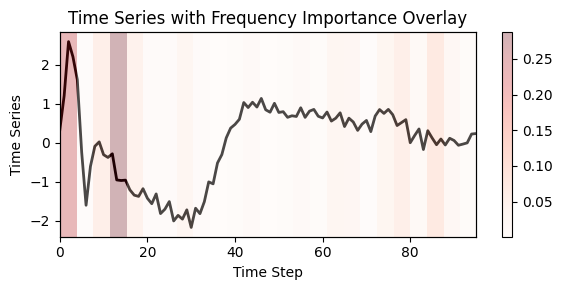

In [503]:
importance = cf['perturbation'].delta_real.abs().detach().cpu().numpy()[0,0,:,:].sum(axis=0)
x_data = x.detach().cpu().numpy().flatten()

fig, ax = plt.subplots(figsize=(6, 3))
ax2 = ax.twinx()

# Plot the line first
line = ax.plot(x_data, color='black', linewidth=2, label='Time Series',zorder=5)

# Plot the heatmap with proper extent
importance_norm = torch.softmax(torch.tensor(importance), 0).repeat(1,1).numpy()
importance_2d = importance_norm.T

# Set extent to match the x-axis range
extent = [0, len(x_data)-1, importance_norm.min(), importance_norm.max()]
im = ax2.imshow(importance_2d.T, cmap='Reds', aspect='auto', 
                extent=extent, alpha=0.3, zorder=0)

fig.colorbar(im)


ax.set_xlabel('Time Step')
ax.set_ylabel('Time Series')
ax2.set_yticks([])
#ax2.set_ylabel('Importance')
#ax.tick_params(axis='y', labelcolor='blue')
#ax2.tick_params(axis='y', labelcolor='red')

plt.title('Time Series with Frequency Importance Overlay')
plt.tight_layout()
plt.show()

0
tensor([1], device='cuda:0')
tensor([[0.3368, 0.6632]], device='cuda:0')


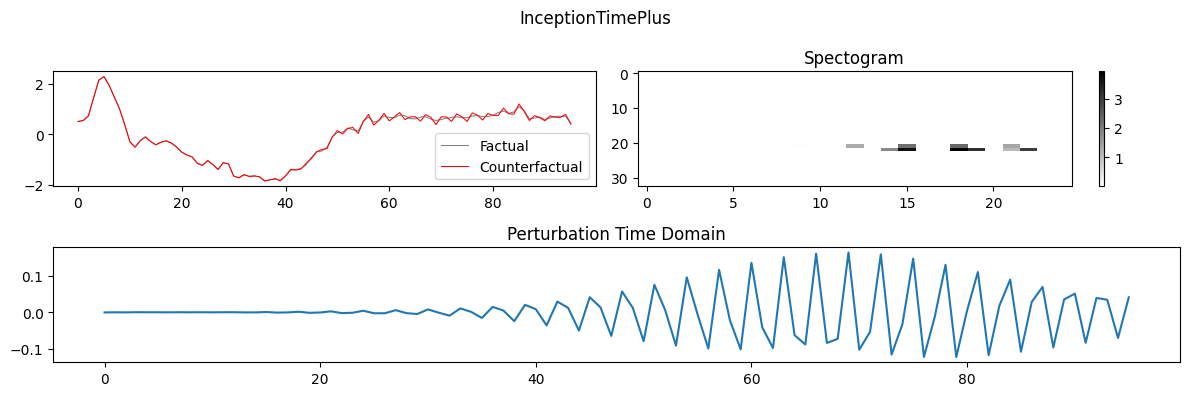

In [615]:
clf_resnet = load_learner(f"../models/InceptionTimePlus-{dataname}.pkl",cpu=False)


device = "cuda" if torch.cuda.is_available() else 'cpu'

f_gen = TSCounterfactualGenerator(
    clf_resnet,
    perturbation_cls=STFTPerturbation,
    lam_perturb=0.0050,
    lam_time=0.01,
    steps=500,
    hop_length=2,
    n_fft=64,
    device=device
)

i = 0
x = torch.tensor(X[i]).unsqueeze(0).to(device)  # (1, C, T)

classmap  ={s: c for c,s in enumerate(set(y.tolist()))}
print(classmap[y[i]])
if classmap[y[i]]== 1:
    target = torch.tensor([0], dtype=torch.long).to(device)
else:
    target = torch.tensor([1], dtype=torch.long).to(device)

print(target)

cf = cf_gen.generate(x, target)

x_cf = cf["x_cf"]


fig = plt.figure(figsize=(12,4))
fig.suptitle("InceptionTimePlus")
ax0 = fig.add_subplot(221)
ax0.plot(x.detach().cpu().numpy().flatten(),label='Factual',c='gray',lw=0.75,alpha=1.0)
ax0.plot(x_cf.detach().cpu().flatten(),label='Counterfactual',c='red',lw=0.75,alpha=1.0)
ax0.legend()
ax1 = fig.add_subplot(222)



try:
    im = ax1.imshow(cf['perturbation'].delta_real.detach().abs().cpu().numpy()[0,0,:,:],cmap='binary',aspect='auto')
    fig.colorbar(im)
    ax1.set_title('Spectogram')
except:
    #ax1.plot(cf['perturbation'].delta_real.detach().cpu().numpy().flatten())
    im = ax1.imshow(torch.stft(cf['perturbation'].delta_real.squeeze(0),64,hop_length=4,return_complex=True)[0,:,:].detach().cpu().numpy().real,cmap='seismic',aspect='auto')
    fig.colorbar(im)
    ax1.set_title('Spectogram')
#ax1.hist(cf['delta_real'].flatten())
ax2 = fig.add_subplot(212)
ax2.set_title('Perturbation Time Domain')
ax2.plot(x.detach().cpu().numpy().flatten()-x_cf.detach().cpu().numpy().flatten())
# #ax2.set_yscale('log')
print(torch.softmax(clf.model(x_cf.detach().to(device)),1))
fig.tight_layout()

1
tensor([0], device='cuda:0')
tensor([[0.0672, 0.9328]], device='cuda:0')


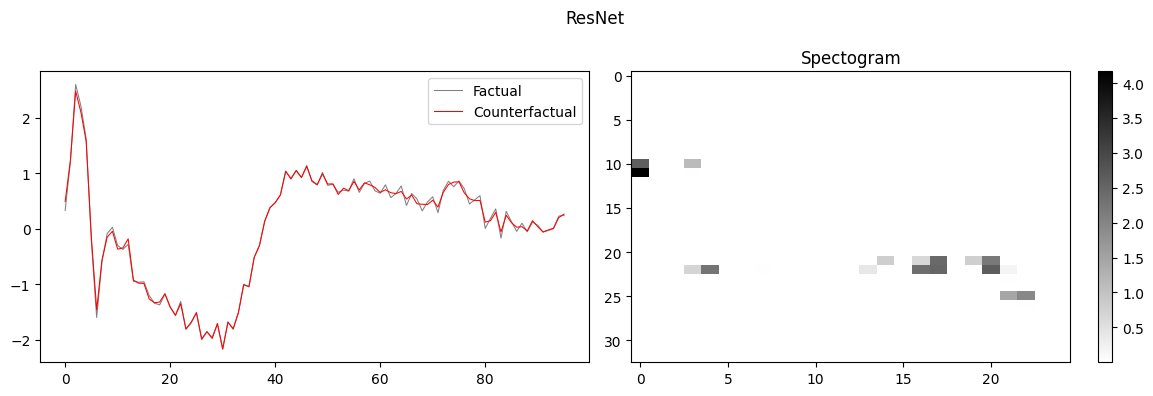

In [605]:
clf_resnet = load_learner(f"../models/ResNet-{dataname}.pkl",cpu=False)


device = "cuda" if torch.cuda.is_available() else 'cpu'

f_gen = TSCounterfactualGenerator(
    clf_resnet,
    perturbation_cls=STFTPerturbation,
    lam_perturb=0.010,
    lam_time=0.001,
    steps=500,
    hop_length=4,
    n_fft=64,
    device=device
)

i = 8
x = torch.tensor(X[i]).unsqueeze(0).to(device)  # (1, C, T)

classmap  ={s: c for c,s in enumerate(set(y.tolist()))}
print(classmap[y[i]])
if classmap[y[i]]== 1:
    target = torch.tensor([0], dtype=torch.long).to(device)
else:
    target = torch.tensor([1], dtype=torch.long).to(device)

print(target)

cf = cf_gen.generate(x, target)

x_cf = cf["x_cf"]


fig = plt.figure(figsize=(12,4))
fig.suptitle("ResNet")
ax0 = fig.add_subplot(121)
ax0.plot(x.detach().cpu().numpy().flatten(),label='Factual',c='gray',lw=0.75,alpha=1.0)
ax0.plot(x_cf.detach().cpu().flatten(),label='Counterfactual',c='red',lw=0.75,alpha=1.0)
ax0.legend()
ax1 = fig.add_subplot(122)



try:
    im = ax1.imshow(cf['perturbation'].delta_real.detach().abs().cpu().numpy()[0,0,:,:],cmap='binary',aspect='auto')
    fig.colorbar(im)
    ax1.set_title('Spectogram')
except:
    #ax1.plot(cf['perturbation'].delta_real.detach().cpu().numpy().flatten())
    im = ax1.imshow(torch.stft(cf['perturbation'].delta.squeeze(0),64,hop_length=4,return_complex=True)[0,:,:].detach().cpu().numpy().real,cmap='seismic',aspect='auto')
    fig.colorbar(im)
    ax1.set_title('Spectogram')
#ax1.hist(cf['delta_real'].flatten())
# ax2 = fig.add_subplot(212)
# ax2.set_title('Perturbation Time Domain')
# ax2.plot(x.detach().cpu().numpy().flatten()-x_cf.detach().cpu().numpy().flatten())
# #ax2.set_yscale('log')
print(torch.softmax(clf.model(x_cf.detach().to(device)),1))
fig.tight_layout()

In [574]:
from tslearn.metrics import SoftDTWLossPyTorch

In [575]:
sdtw = SoftDTWLossPyTorch(gamma=0.1)

sdtw(x_cf,x)

tensor([0.6623], device='cuda:0')